In [1]:
import numpy as np
import pandas as pd
import math

## Part 1. Data Preprocessing

In [2]:
df = pd.read_csv('AAPL_max.csv')
df = df.iloc[-math.ceil(len(df) * 0.3):] # only use last 30% of data
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
6974,2008-08-04,22.371429,22.557142,21.844286,21.889999,18.950113,148131900.0
6975,2008-08-05,22.202858,22.971428,22.117144,22.948572,19.866512,172092900.0
6976,2008-08-06,22.852858,23.914286,22.571428,23.455715,20.305553,197852200.0


In [3]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

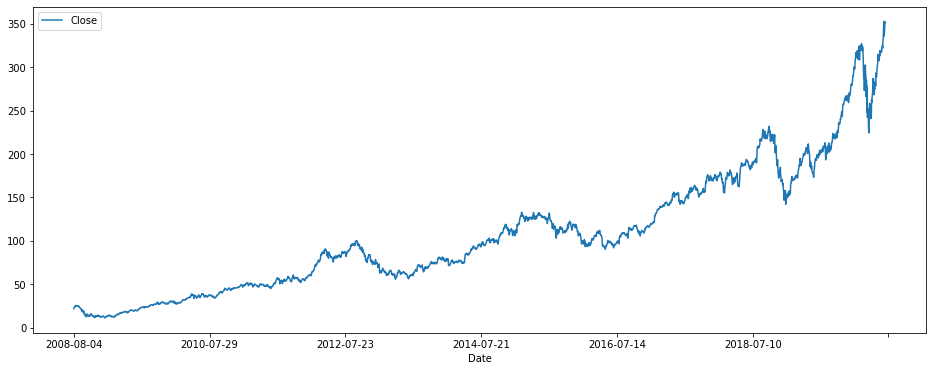

In [4]:
df.plot(x = 'Date', y = 'Close', figsize = (16, 6))

In [5]:
# use Close price for prediction
df = df[['Date', 'Close']]

In [6]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dataset = sc.fit_transform(pd.DataFrame(df.Close).values)

## Part 2. Training

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
                        
# parameters
lags = 3
test_size = 0.2
model_seed = 100
n_estimators = 40              # Number of boosted trees to fit
max_depth = 5                  # Maximum tree depth for base learners
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”)
min_child_weight = 2           # Minimum sum of instance weight(hessian) needed in a child
subsample = 1                  # Subsample ratio of the training instance
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree

# use lags of data as features
x, y = [], []
for i in range(lags, len(dataset)):
    x.append(dataset[i-lags:i])
    y.append(dataset[i])
x, y = np.array(x), np.array(y)

# split
train_size = len(x) - math.floor(len(x) * test_size)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

# reshape to reduce one dimension as expected input of XGBRegressor
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

# init XGB
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

model.fit(x_train, y_train)

# predict
y_pred = model.predict(x_test)
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test)

# eval
rmse = math.sqrt(mean_squared_error(y_test, y_pred))


[15:50:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [8]:
output_df = pd.DataFrame()
output_df['date'] = df.Date[train_size+lags:].values
output_df['actual'] = np.reshape(y_test, y_test.shape[0])
output_df['pred'] = np.reshape(y_pred, y_pred.shape[0])
output_df

,date,actual,pred
0,2018-02-05,156.490005,160.058136
1,2018-02-06,163.029999,157.426849
2,2018-02-07,159.539993,163.867126
3,2018-02-08,155.149994,159.799545
4,2018-02-09,156.410004,154.492172
...,...,...,...
592,2020-06-12,338.799988,176.525925
593,2020-06-15,342.989990,176.525925
594,2020-06-16,352.079987,176.525925
595,2020-06-17,351.589996,176.525925


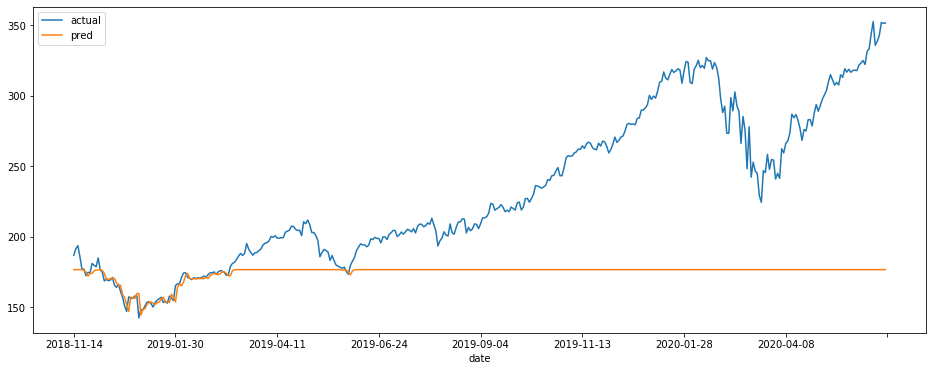

In [9]:
output_df_ex = output_df.iloc[-400:]
output_df_ex.reset_index(drop = True, inplace = True)
output_df_ex.plot(x = 'date', y = 'actual', figsize = (16, 6), legend = True)
output_df_ex.pred.plot(legend = True)